In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.linalg import expm, cosm

In [9]:
7.7*9.2*3.9

276.27599999999995

In [3]:
5.2*6.9*7.7

276.276

In [10]:
9.2*3.3*9.1

276.27599999999995

In [24]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)  # 2 ancilla + 1 system

def prepare_equal_superposition():
    """Prepare uniform superposition over 4 states: |00>, |01>, |10>, |11>"""
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

def select_four_evolutions():
    """Apply:
    - e^{-2iH} on |00>
    - e^{-iH}  on |01>
    - e^{+iH}  on |10>
    - e^{+2iH} on |11>
    """
    sys = 2
    # |00⟩ → e^{-2iZ}
    qml.ctrl(qml.RZ, control=[0], control_values=0)(-2.0, wires=sys)

    # |01⟩ → e^{-iZ}

    qml.ctrl(qml.RZ, control=[0], control_values=1)(2.0, wires=sys)


    # |10⟩ → e^{+iZ}

    qml.ctrl(qml.RZ, control=[1], control_values=0)(-2.0, wires=sys)


    # |11⟩ → e^{+2iZ}

    qml.ctrl(qml.RZ, control=[1], control_values=1)(2.0, wires=sys)


@qml.qnode(dev)
def four_term_circuit():
    prepare_equal_superposition()
    select_four_evolutions()
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    return qml.state()

U = qml.matrix(four_term_circuit)()

# extract top-left 2x2 block where ancilla in |00⟩
def extract_U_on_system_given_ancilla00(U):
    #return U[np.ix_([0,1],[0,1])]
    return U[:2, :2]

U_eff = extract_U_on_system_given_ancilla00(U)

# build target operator: (e^{-2iZ} + e^{-iZ} + e^{iZ} + e^{2iZ}) / 4
Z = np.array([[1,0],[0,-1]])
target = (
    scipy.linalg.expm(-2j*Z)
    + np.eye(2) +
    np.eye(2) +
    scipy.linalg.expm(2j*Z)
) / 4

error = np.linalg.norm(U_eff - target)

print("Circuit effective operator:\n", U_eff)
print("\nTarget operator:\n", target)
print(f"\nOperator error norm: {error:.3e}")


Circuit effective operator:
 [[0.29192658-3.65441562e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.29192658+3.65441562e-17j]]

Target operator:
 [[0.29192658+0.j 0.        +0.j]
 [0.        +0.j 0.29192658+0.j]]

Operator error norm: 9.399e-17


(<Figure size 900x400 with 1 Axes>, <Axes: >)

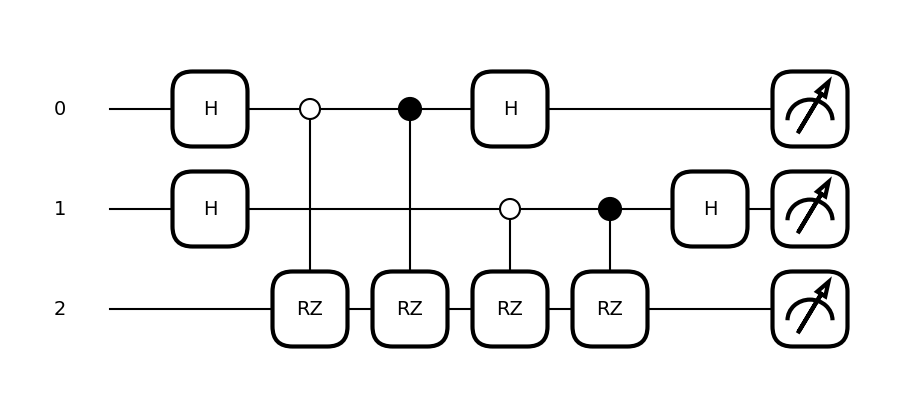

In [11]:
qml.draw_mpl(four_term_circuit)()

(<Figure size 900x400 with 1 Axes>, <Axes: >)

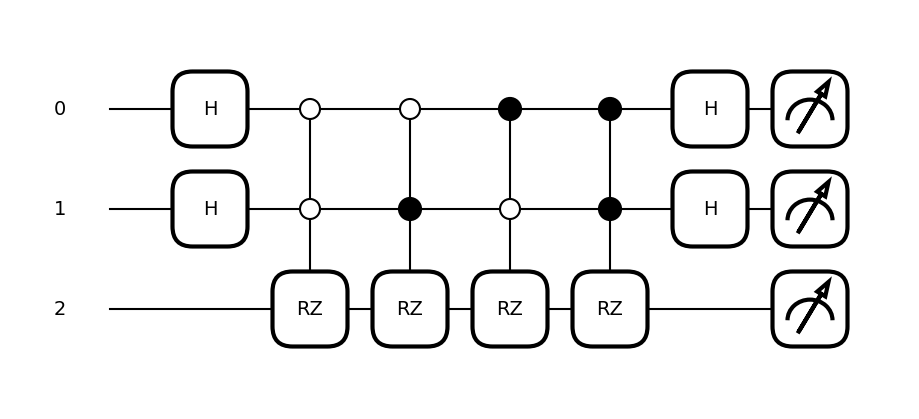

In [28]:
def lcu_circuit():
    sys = 2
    # |00⟩ → e^{-2iZ}
    qml.ctrl(qml.RZ, control=[0, 1], control_values=[0, 0])(-4.0, wires=sys)

    # |01⟩ → e^{-iZ}

    qml.ctrl(qml.RZ, control=[0, 1], control_values=[0, 1])(0, wires=sys)


    # |10⟩ → e^{+iZ}

    qml.ctrl(qml.RZ, control=[0, 1], control_values=[1, 0])(0, wires=sys)


    # |11⟩ → e^{+2iZ}

    qml.ctrl(qml.RZ, control=[0, 1], control_values=[1, 1])(4.0, wires=sys)
@qml.qnode(dev)
def four_term_circuit():
    prepare_equal_superposition()
    lcu_circuit()
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    return qml.state()

qml.draw_mpl(four_term_circuit)()

pad_len 8
weights: [0.4472136 0.4472136 0.4472136 0.        0.        0.4472136 0.4472136
 0.       ]


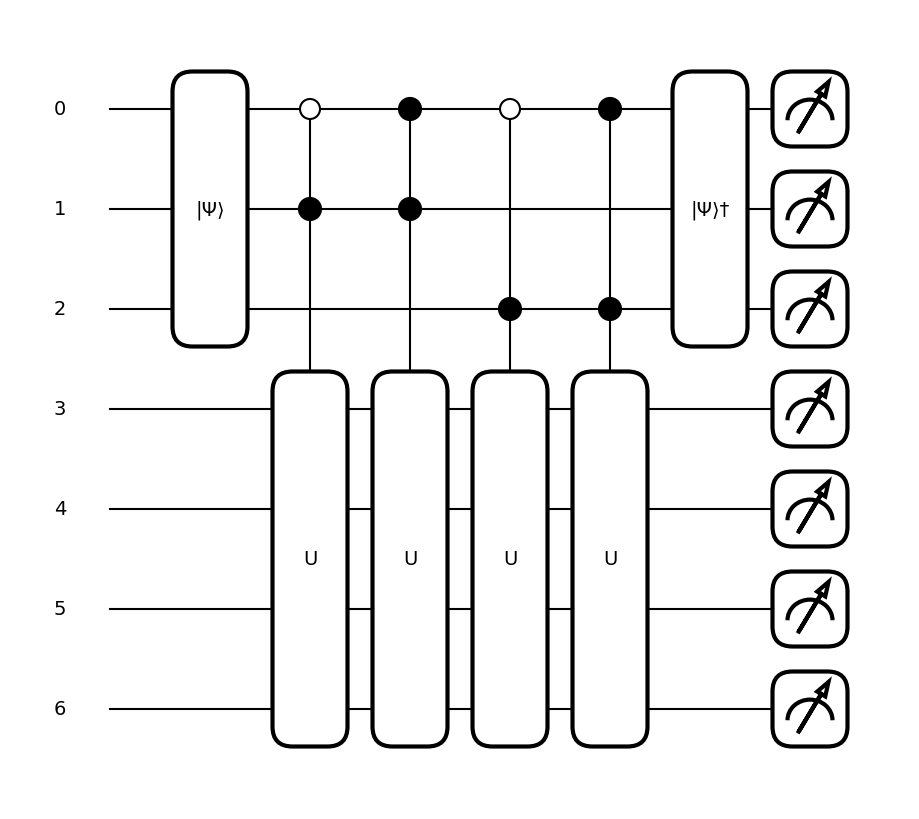

In [49]:
n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
H_shifted1 = shift_and_normalize_H(H)
# init_state = np.ones(dim) / np.sqrt(dim)

init_state = np.zeros(dim)
init_state[0] = 1

def dirichlet_reduced(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in np.arange(-max_N, 1)])
    beta_k = np.array([1/(2* max_N + 1) for k in np.arange(1, max_N + 1)])

    pad_len = 2 ** int(np.ceil(np.log2(len(k_vals_full))))
    print('pad_len', pad_len)

    #
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:max_N+1] = alpha_k
    alpha_padded[int(pad_len/2+1):int(pad_len/2+1+max_N)] = beta_k


    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))

    print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    # U_list = [expm(-2.0j * k * H_shifted1) for k in k_vals_full]
    # U_list += [np.eye(dim)] * (pad_len - len(U_list))
    # U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        for l in range(1, n_anc):
            qml.ControlledQubitUnitary(
            expm(2.0j * 2**l * H_shifted1),
            wires=[0, l]+system_wires,
            control_values=[0, 1], # sigma=0, anc_l=1

        )

        # --- 施加 Controlled-U^(-k) (对应图中 sigma=1, 即实心点) ---
        # 控制条件: sigma=1 AND anc_l=1
            qml.ControlledQubitUnitary(
            expm(-2.0j * 2**l * H_shifted1),
            wires=[0, l]+system_wires,
            control_values=[1, 1], # sigma=1, anc_l=1

        )
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # full_state = block_encoding()
    # reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    # system_state = reshaped[0, :]
    # be_state = system_state
    #
    # success_prob = np.sum(np.abs(be_state) ** 2)
    # be_state /= np.linalg.norm(be_state)
    # fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    # return fidelity, success_prob
    qml.draw_mpl(block_encoding)()
    return


dirichlet_reduced(2)

In [28]:
max_N = 2
k_vals_full = np.arange(-max_N, max_N + 1)
alpha_k = np.array([np.sqrt(1/(2* max_N + 1)) for k in np.arange(-max_N, 1)])
beta_k = np.array([np.sqrt(1/(2* max_N + 1)) for k in np.arange(1, max_N + 1)])

pad_len = 2 ** int(np.ceil(np.log2(len(k_vals_full))))
print('pad_len', pad_len)


alpha_padded = np.zeros(pad_len)
alpha_padded[:max_N+1] = alpha_k
alpha_padded[int(pad_len/2+1):int(pad_len/2+1+max_N)] = beta_k

pad_len 8


In [29]:
alpha_padded

tensor([0.4472136, 0.4472136, 0.4472136, 0.       , 0.       , 0.4472136,
        0.4472136, 0.       ], requires_grad=True)

In [30]:
np.sqrt(alpha_padded / np.sum(alpha_padded))

tensor([0.4472136, 0.4472136, 0.4472136, 0.       , 0.       , 0.4472136,
        0.4472136, 0.       ], requires_grad=True)

In [9]:
k_vals_full

tensor([-1,  0,  1], requires_grad=True)

In [10]:
alpha_k

tensor([0.33333333, 0.33333333], requires_grad=True)

In [11]:
beta_k

tensor([0.33333333], requires_grad=True)

In [14]:
int(pad_len/2)

2